# GAN 影像自動生成

- 目標：使用生成對抗網路(GAN)生成數字的圖
- 注意：要將執行環境切換至 GPU

## 步驟一：取得 MNIST Dataset
* 使用 keras API
* 毋需再次切分資料集(i.e., train_test_split)


In [1]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train - 127.5) / 127.5
# x_train = x_train / 256.0

img_rows = 28
img_cols = 28
channels = 1
IMG_shape = (img_rows, img_cols, channels)
x_train = x_train.reshape(60000, img_rows, img_cols, channels)

print(f"x_train 的形狀是 {x_train.shape}")

11490434/11490434 [==============================] - 1s 0us/step
x_train 的形狀是 (60000, 28, 28, 1)


## 步驟二：視覺化影像

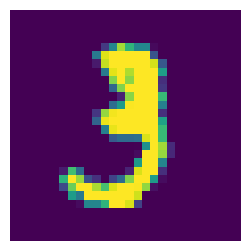

影像對應數值是 3
影像大小是 (28, 28, 1)


In [2]:
import matplotlib.pyplot as plt

# 決定要繪製的影像
img_index = 10
img = x_train[img_index]
lab = y_train[img_index]

# 繪製影像
plt.figure(figsize=(3,3))
plt.imshow(img[:,:,0])
plt.axis("off")
plt.show()

print(f"影像對應數值是 {lab}")
print(f"影像大小是 {img.shape}")

## 步驟三：建置 GAN
* Discriminator => 訓練時使用
* Generator => 合併時使用
* Combined => 訓練時使用

In [3]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# ========================= #
# 建置 Discriminator Network
# ========================= #

Discriminator = Sequential([
    Flatten(input_shape=IMG_shape), # IMG_shape = (28, 28, 1)
    Dense(512, activation=LeakyReLU(alpha=0.2)),
    Dense(256, activation=LeakyReLU(alpha=0.2)),
    Dense(1, activation='sigmoid')
])

Discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=3e-4, beta_1=0.5),
    metrics=["accuracy"] # 很好奇 Discriminator 是不是一直都能夠分辨真偽照片
)

In [4]:
# =============================== #
# 建置 "包含" Generator 的 Network
# =============================== #

LatentVec_shape = (100,) # 最初的潛在向量 latent vector 長度可自訂

Generator = Sequential([
    Dense(256, activation=LeakyReLU(alpha=0.2), input_shape=LatentVec_shape),
    BatchNormalization(momentum=0.8),
    Dense(512, activation=LeakyReLU(alpha=0.2)),
    BatchNormalization(momentum=0.8),
    Dense(1024, activation=LeakyReLU(alpha=0.2)),
    BatchNormalization(momentum=0.8),
    Dense(784, activation='tanh'),
    Reshape(IMG_shape)
])

Generator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=3e-4, beta_1=0.5),
)

"""[重點一]"""
# 建置完 Generator 之後，我們還需要將 Discriminator 與之合併，才能進行訓練！
# 因為 Generator 產出一張照片之後，它並不知道自己生成的影像是好是壞，所以它需要 Discriminator 的協助判斷其品質。

"""[重點二]"""
# 在合併之前，需要將 Discriminator 的訓練參數 "固定" (freeze)

LatentVec = Input(shape=(100,))
GeneratedImg = Generator(LatentVec)
Discriminator.trainable = False  # 務必要調整成 False，才能達到 Freeze 的效果
Decision = Discriminator(GeneratedImg)

"""[重點三]"""
# 使用 Functional API 的方式建置 Combined Network
Combined = Model(LatentVec, Decision)

Combined.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=3e-4, beta_1=0.5),
)

In [5]:
# 定義 Helper Function
import numpy as np

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = Generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [6]:
# 因為待會需要儲存影像，所以先建立資料夾
# ! rm -r images # 若已經有建立，想要刪除原有的資料夾，可以 Un Comment 此行程式碼
! mkdir images

In [8]:
Epochs = 2000
BatchSize = 512
save_interval = 100  # 每隔幾個 epoch 就儲存一次 Fake Image

D_Loss_List = []
D_Acc_List = []
G_Loss_List = []

HalfBatch = int(BatchSize / 2) # 為什麼會需要 half_batch？

for epoch in range(Epochs):

    # =================== #
    #  訓練 Discriminator
    # =================== #

    # 隨機挑選 RealImgs，總共有 batch_size/2 張影像
    idx = np.random.randint(0, 60000, HalfBatch)
    RealImgs = x_train[idx]

    # 利用 Generator 生成 FakeImgs，總共有 batch_size/2 張影像
    LatentVec = np.random.normal(0, 1, (HalfBatch, 100))
    FakeImgs = Generator.predict(LatentVec)

    d_loss_real = Discriminator.train_on_batch(RealImgs, np.ones((HalfBatch, 1)))  # ones : [[1], [1], [1], [1], [1], ...]
    d_loss_fake = Discriminator.train_on_batch(FakeImgs, np.zeros((HalfBatch, 1))) # zeros: [[0], [0], [0], [0], [0], ...]
    d_loss = np.add(d_loss_real, d_loss_fake) / 2
    D_Loss_List.append(d_loss[0])
    D_Acc_List.append(d_loss[1])

    # =============== #
    #  訓練 Generator
    # =============== #
    for _ in range(4): # 讓 Generator 訓練 3 次？
      LatentVec = np.random.normal(0, 1, (BatchSize, 100))
      Decision = np.array([1] * BatchSize)
      g_loss = Combined.train_on_batch(LatentVec, Decision)
    G_Loss_List.append(g_loss)

    # ============= #
    # 列印當前訓練成果
    # ============= #
    print(f"Epoch: {epoch}/{Epochs}, D. Acc: {'%.5f' % d_loss[1]}, D. Loss: {'%.5f' % d_loss[0]}, G. Loss: {'%.5f' % g_loss}")

    # ========================================== #
    # 每隔 100 個 epoch 就儲存一次 Fake Image 的結果
    # ========================================== #
    if (epoch % save_interval == 0) or (epoch+1) == Epochs:
        save_imgs(epoch)

8/8 [==============================] - 0s 4ms/step
Epoch: 0/2000, D. Acc: 0.58398, D. Loss: 0.64753, G. Loss: 0.72916
8/8 [==============================] - 0s 2ms/step
Epoch: 1/2000, D. Acc: 0.48633, D. Loss: 0.69283, G. Loss: 0.68320
8/8 [==============================] - 0s 2ms/step
Epoch: 2/2000, D. Acc: 0.42773, D. Loss: 0.72334, G. Loss: 0.69627
8/8 [==============================] - 0s 2ms/step
Epoch: 3/2000, D. Acc: 0.47070, D. Loss: 0.71028, G. Loss: 0.70597
8/8 [==============================] - 0s 2ms/step
Epoch: 4/2000, D. Acc: 0.50195, D. Loss: 0.69360, G. Loss: 0.72699
8/8 [==============================] - 0s 2ms/step
Epoch: 5/2000, D. Acc: 0.53906, D. Loss: 0.70353, G. Loss: 0.71623
8/8 [==============================] - 0s 2ms/step
Epoch: 6/2000, D. Acc: 0.46680, D. Loss: 0.72562, G. Loss: 0.73355
8/8 [==============================] - 0s 2ms/step
Epoch: 7/2000, D. Acc: 0.44336, D. Loss: 0.71451, G. Loss: 0.73943
8/8 [==============================] - 0s 3ms/step
Epoch

# 步驟四：繪製 Accuracy 與 Loss

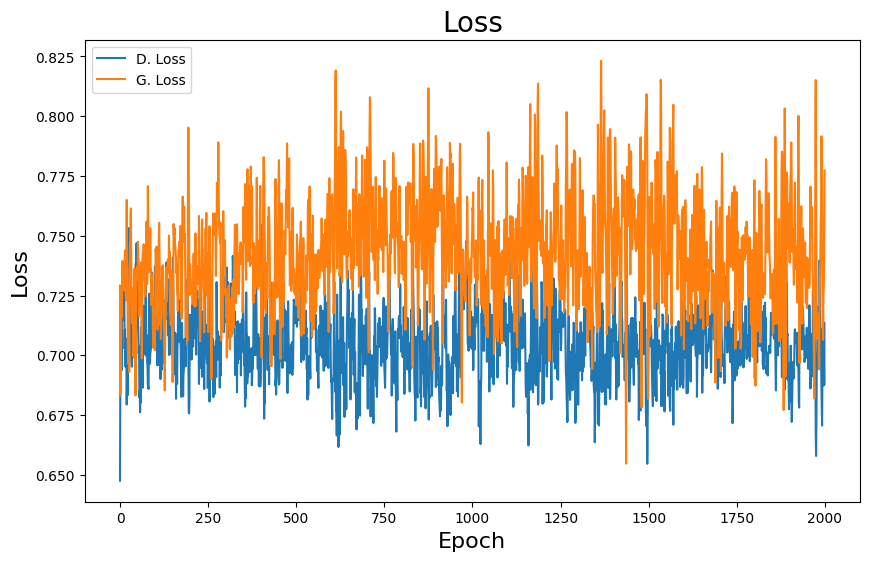

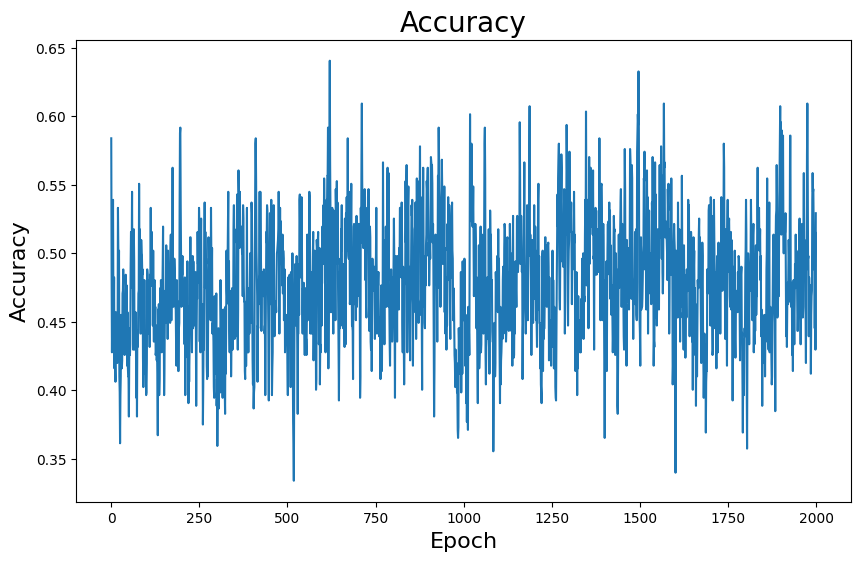

In [9]:
# 本次的訓練成果

import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10,6))
plt.plot(D_Loss_List, label="D. Loss")
plt.plot(G_Loss_List, label="G. Loss")
plt.title("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend()
plt.show()


# Accuracy
plt.figure(figsize=(10,6))
plt.plot(D_Acc_List, label="D. Loss")
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show()

# 步驟五: 使用 Generator

1/1 [==============================] - 0s 19ms/step


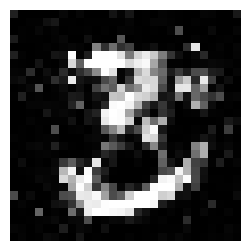

In [14]:
from numpy.random import randn
import matplotlib.pyplot as plt

vector = randn(100)
vector = vector.reshape(1, 100)

GeneratedImage = Generator.predict(vector)

plt.figure(figsize=(3,3))
plt.imshow(GeneratedImage[0, :, :, 0], cmap="gray")
plt.axis("off")
plt.show()